# Step 1: Setup and Imports

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist

Using TensorFlow backend.


# Step 2: Load and Visualize Fashion MNIST Dataset

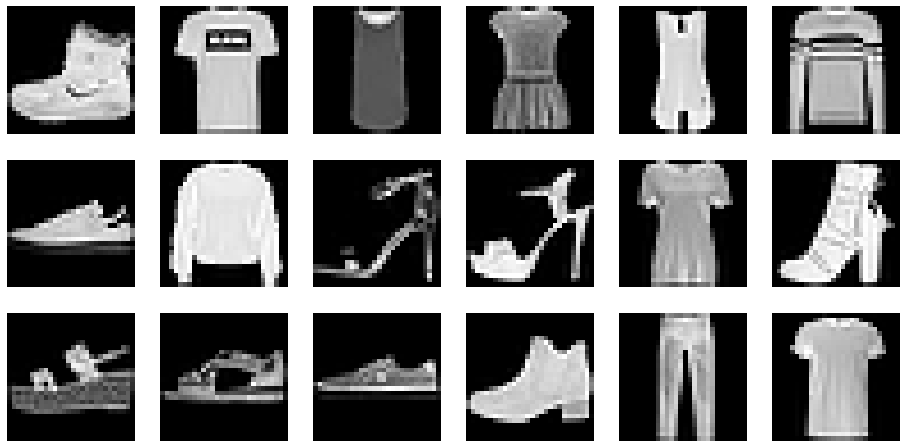

[9 0 0 3 0 2 7 2 5 5]


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

print(y_train[0:10])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

## Step 2.1: Labeling the Pictures

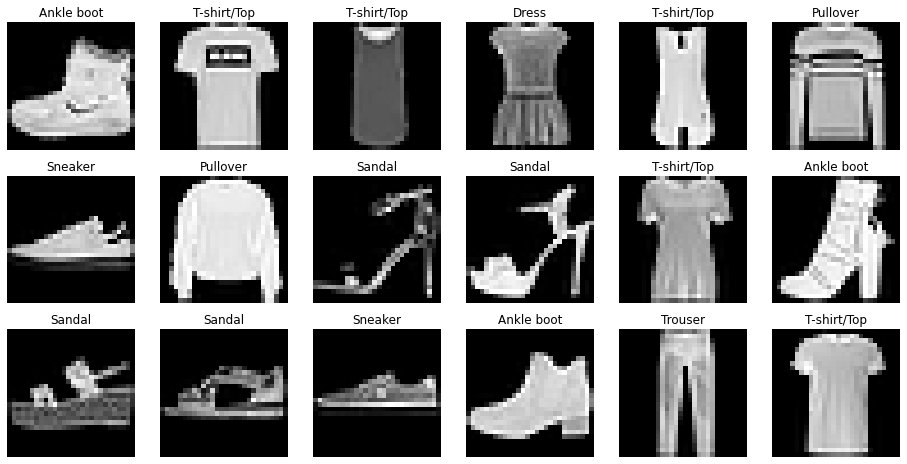

In [47]:
id_to_labels = {0: "T-shirt/Top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(id_to_labels[y_train[i]])
    plt.axis("off")
plt.show()

# Step 3: Prepare Data for Fully-Connected VAE

(60000, 784) (10000, 784)


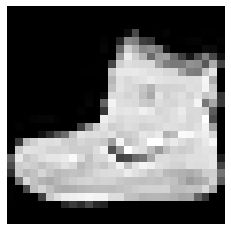

In [48]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_standard.shape, x_test_standard.shape)

plt.imshow(x_train_standard[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

# Step 4: Build the Fully-Connected VAE

## 4.1 Define the Encoder

In [49]:
original_dim = 784
intermediate_dim = 256
latent_dim = 2

def make_encoder(original_dim, intermediate_dim, latent_dim):
    x = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var], name="mlp_encoder")

encoder = make_encoder(original_dim, intermediate_dim, latent_dim)
print(encoder.summary())

Model: "mlp_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          200960      input_7[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2)            514         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 2)            514         dense_16[0][0]                   
Total params: 201,988
Trainable params: 201,988
Non-trainable params: 0
________________

## 4.2 Define the Sampling Layer

In [50]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,), name="latent_sampler")

## 4.3 Define the Decoder

In [51]:
def make_decoder(latent_dim, intermediate_dim, original_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(original_dim, activation='sigmoid')(x)
    return Model(decoder_input, x, name="mlp_decoder")

decoder = make_decoder(latent_dim, intermediate_dim, original_dim)
print(decoder.summary())

Model: "mlp_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_20 (Dense)             (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________
None


## 4.4 Test the Untrained Decoder

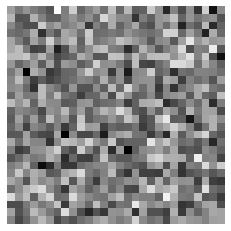

In [52]:
random_z_from_prior = np.random.normal(loc=0, scale=1, size=(1, latent_dim))
generated = decoder.predict(random_z_from_prior)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## 4.5 Build the Full VAE

In [53]:
def make_vae(input_shape, encoder, decoder, sampling_layer):
    x = Input(shape=input_shape, name="input")
    z_mean, z_log_var = encoder(x)
    z = sampling_layer([z_mean, z_log_var])
    x_decoded_mean = decoder(z)
    vae = Model(x, x_decoded_mean)

    xent_loss = original_dim * metrics.binary_crossentropy(
        K.flatten(x), K.flatten(x_decoded_mean))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = make_vae((original_dim,), encoder, decoder, sampling_layer=sampling_layer)
print(vae.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
mlp_encoder (Model)             [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           mlp_encoder[1][0]                
                                                                 mlp_encoder[1][1]                
__________________________________________________________________________________________________
mlp_decoder (Model)             (None, 784)          202256      latent_sampler[0][0]      

# Step 5: Train the Fully-Connected VAE (or Load Weights)

In [54]:
# If you encounter error on vae.load_weights(), follow the steps below

# Step 1:
# Path     : ...\python-keras-deep-learning\myenv\lib\site-packages\keras\engine\saving.py

# Step 2:
# Find     : original_keras_version = f.attrs['keras_version'].decode('utf8')
# Replace  : original_keras_version = str(f.attrs['keras_version'])

# Step 3:
# Find     : original_backend = f.attrs['backend'].decode('utf8')
# Replace  : original_backend = str(f.attrs['backend'])

# Step 4:
# Save the file and restart your Python kernel


vae.fit(x_train_standard, epochs=5, batch_size=100, validation_data=(x_test_standard, None))
vae.load_weights("Files/weights_standard.h5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 80us/step - loss: 305.0116 - val_loss: 282.8850
Epoch 2/5
60000/60000 [==============================] - 3s 52us/step - loss: 278.7267 - val_loss: 276.9156
Epoch 3/5
60000/60000 [==============================] - 3s 52us/step - loss: 274.2794 - val_loss: 274.1383
Epoch 4/5
60000/60000 [==============================] - 3s 51us/step - loss: 271.7091 - val_loss: 272.3947
Epoch 5/5
60000/60000 [==============================] - 3s 51us/step - loss: 270.1138 - val_loss: 270.9843


# Step 6: Generate and Visualize Samples from the Trained Fully-Connected VAE

## 6.1 Generate Random Samples

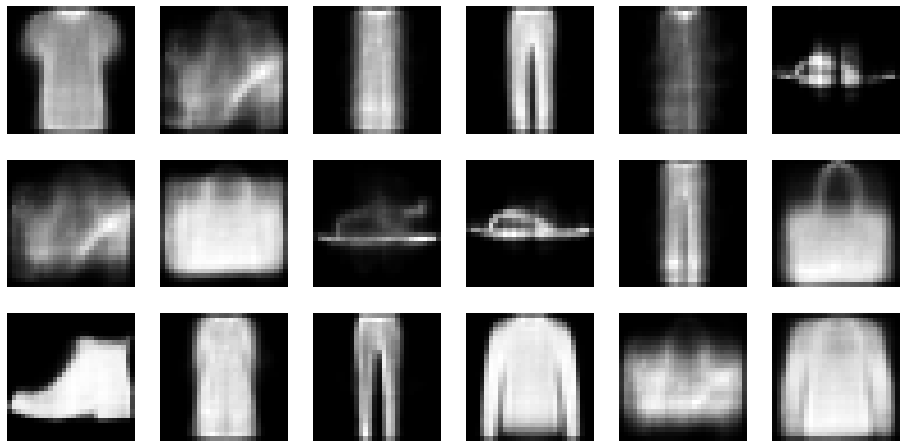

In [55]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    random_z_from_prior = np.random.normal(size=(1, latent_dim))
    generated = decoder.predict(random_z_from_prior)
    plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

## 6.2 Visualize the Latent Space

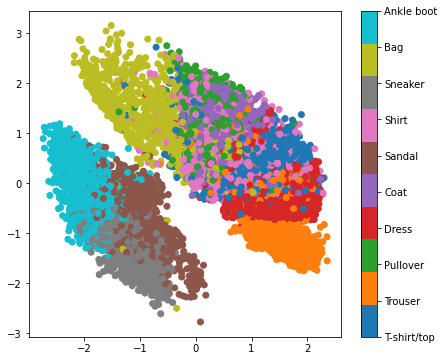

In [56]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

x_test_encoded, x_test_encoded_log_var = encoder.predict(x_test_standard, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

## 6.3 Visualize the Latent Manifold

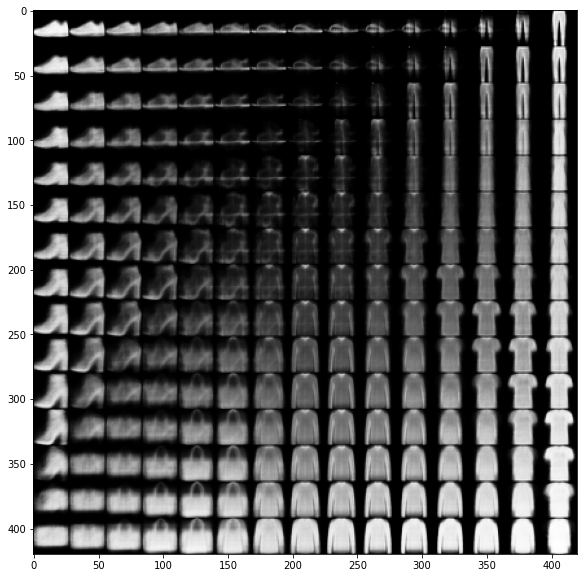

In [57]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Step 7: Build the Convolutional VAE

## 7.1 Prepare Data for Convolutional VAE

In [58]:
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)
print(x_train_conv.shape, x_test_conv.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## 7.2 Define the Convolutional Encoder

In [59]:
from keras.layers import BatchNormalization

img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2

def make_conv_encoder(img_rows, img_cols, img_chns, latent_dim, intermediate_dim):
    inp = x = Input(shape=(img_rows, img_cols, img_chns))
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu', strides=(2, 2))(x_conv)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x_conv)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu', strides=(2, 2))(x_conv)
    flat = Flatten()(x_conv)
    hidden = Dense(intermediate_dim, activation='relu')(flat)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=inp, outputs=[z_mean, z_log_var], name='convolutional_encoder')

conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns, latent_dim, intermediate_dim)
print(conv_encoder.summary())

Model: "convolutional_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 28, 28, 32)   128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 32)   9248        batch_normalization_13[0][0]     
______________________________________________________________________________

## 7.3 Reuse the Sampling Layer (4.2 Define the Sampling Layer)

In [60]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,), name="latent_sampler")

## 7.4 Define the Convolutional Decoder

In [61]:
def make_conv_decoder(latent_dim, intermediate_dim, original_dim, spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(filters * spatial_size * spatial_size, activation='relu')(x)
    x = Reshape((spatial_size, spatial_size, filters))(x)

    # First up-sampling:
    x = Conv2DTranspose(filters, kernel_size=3, padding='same', strides=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters, kernel_size=3, padding='same', strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Second up-sampling:
    x = Conv2DTranspose(filters, kernel_size=3, strides=(2, 2), padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Ouput 1 channel of gray pixels values between 0 and 1:
    x = Conv2D(1, kernel_size=2, padding='valid', activation='sigmoid')(x)
    return Model(decoder_input, x, name='convolutional_decoder')

conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim, spatial_size=7, filters=filters)
print(conv_decoder.summary())

Model: "convolutional_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_25 (Dense)             (None, 1568)              202272    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 3

## 7.5 Test the Untrained Decoder

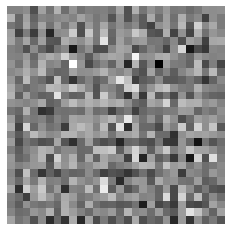

In [62]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## 7.6 Build the Full Convolutional VAE

In [64]:
input_shape = (img_rows, img_cols, img_chns)
vae = make_vae(input_shape, conv_encoder, conv_decoder, sampling_layer)
print(vae.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
convolutional_encoder (Model)   [(None, 2), (None, 2 229796      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           convolutional_encoder[2][0]      
                                                                 convolutional_encoder[2][1]      
__________________________________________________________________________________________________
convolutional_decoder (Model)   (None, 28, 28, 1)    230913      latent_sampler[1][0]      

# Step 8: Train the Convolutional VAE (or Load Weights)

In [66]:
vae.fit(x_train_conv, epochs=1, batch_size=100, validation_data=(x_test_conv, None))
vae.load_weights("Files/weights_convolutional.h5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 140s 2ms/step - loss: 274.2903 - val_loss: 289.5447


# Step 9: Generate and Visualize Samples from the Trained Convolutional VAE

## 9.1 Generate a Random Sample

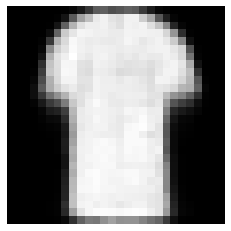

In [67]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## 9.2 Visualize the Latent Space

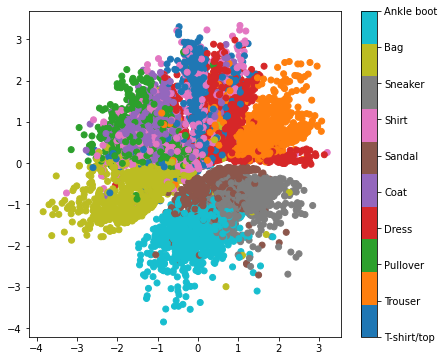

In [68]:
x_test_encoded, _ = conv_encoder.predict(x_test_conv, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.tab10)

cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

## 9.3 Visualize the Latent Manifold

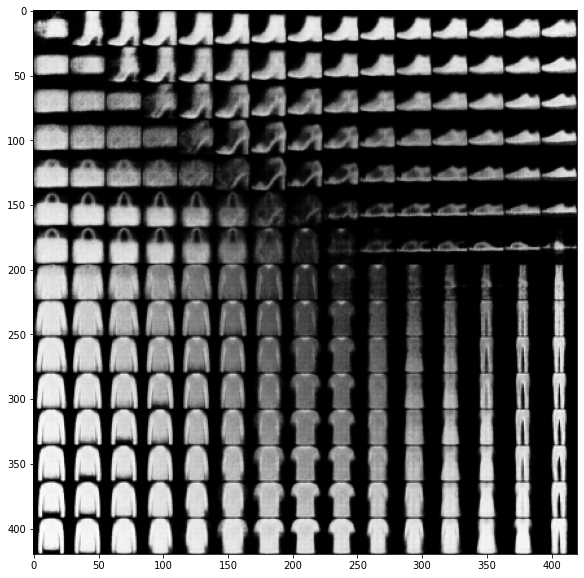

In [69]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = conv_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Step 10: Extensions and Experiments

## Step 10.1: Quantitative Comparison

In [71]:
def compute_reconstruction_loss(model, x_test):
    x_reconstructed = model.predict(x_test)
    x_test_flat = K.flatten(x_test)
    x_reconstructed_flat = K.flatten(x_reconstructed)
    return K.eval(original_dim * metrics.binary_crossentropy(x_test_flat, x_reconstructed_flat))

# For fully-connected VAE
vae_standard = make_vae((original_dim,), encoder, decoder, sampling_layer)
vae_standard.load_weights("Files/weights_standard.h5")
loss_standard = compute_reconstruction_loss(vae_standard, x_test_standard)

# For convolutional VAE
vae_conv = make_vae((img_rows, img_cols, img_chns), conv_encoder, conv_decoder, sampling_layer)
vae_conv.load_weights("Files/weights_convolutional.h5")
loss_conv = compute_reconstruction_loss(vae_conv, x_test_conv)

print("Fully-Connected VAE Loss:", loss_standard)
print("Convolutional VAE Loss:", loss_conv)

Fully-Connected VAE Loss: 256.37787
Convolutional VAE Loss: 253.17262


## Step 10.2: Interpolate in Latent Space

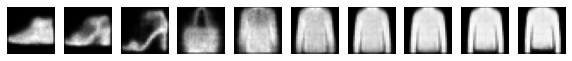

In [72]:
# For convolutional VAE
idx1, idx2 = 0, 1
z1, _ = conv_encoder.predict(x_test_conv[idx1:idx1+1])
z2, _ = conv_encoder.predict(x_test_conv[idx2:idx2+1])
n_steps = 10

plt.figure(figsize=(n_steps, 1))
for i, alpha in enumerate(np.linspace(0, 1, n_steps)):
    z_interp = (1 - alpha) * z1 + alpha * z2
    x_interp = conv_decoder.predict(z_interp)
    plt.subplot(1, n_steps, i + 1)
    plt.imshow(x_interp.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## Step 10.3: Denoising VAE

In [73]:
noise_factor = 0.5
x_train_noisy = x_train_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_conv.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = x_test_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_conv.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

vae.fit(x_train_noisy, epochs=1, batch_size=100, validation_data=(x_test_noisy, None)) # epochs could be higher

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 181s 3ms/step - loss: 470.1456 - val_loss: 461.1159


## Step 10.4: Plotting

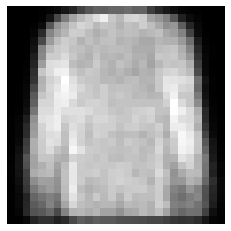

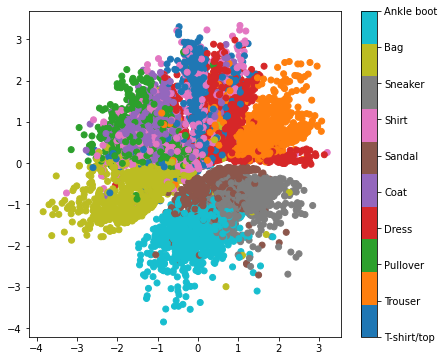

In [74]:
vae.load_weights("Files/weights_convolutional.h5")

generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');
plt.show()

# ### 2D plot of the image classes in the latent space
x_test_encoded, _ = conv_encoder.predict(x_test_conv, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()